<a href="https://colab.research.google.com/github/sushant1212/SAiDL-Summer-Assignment-2021/blob/main/SL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


## Getting Data from ```torchvision```

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15)
])


training_data = datasets.STL10(
    root="data",
    split="train",
    transform=transform,
    download=False
)

test_data = datasets.STL10(
    root="data",
    split='test',
    transform=transform,
    download=False
)

unlabeled = datasets.STL10(
    root="data",
    split="unlabeled",
    transform=transform,
    download=False
)

train_plus_unlabeled = datasets.STL10(
    root="data",
    split="train+unlabeled",
    transform=transform,
    download=False
)

In [ ]:
def imshow(img):
    t1 = torch.tensor([0.485, 0.456, 0.406])
    t2 = torch.tensor([0.229, 0.224, 0.225])
    img[0]*=t2[0]
    img[1]*=t2[1]
    img[2]*=t2[2]

    img[0]+=t1[0]
    img[1]+=t1[1]
    img[2]+=t1[2]

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

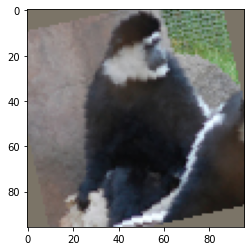

monkey
torch.Size([3, 96, 96])


In [ ]:
labels_map = {
    0: "airplane",
    1: "bird",
    2: "car",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "horse",
    7: "monkey",
    8: "ship",
    9: "truck",
}
img, label = training_data[155]
imshow(img)
print(labels_map[label])
print(img.shape)

In [ ]:
## HYPERPARAMETERS
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 100



## Preparing the dataset using ```DataLoader```

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

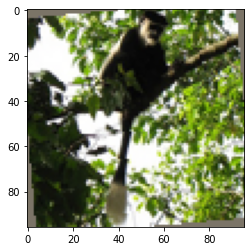

monkey


In [ ]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0]
imshow(img)
print(labels_map[train_labels[0].item()])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import time
import copy

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=EPOCHS, is_inception=False):
    since = time.time()
    model = model.to(device)
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        outputs = outputs.to(device)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
dataloaders = {}
dataloaders['train'] = train_dataloader
dataloaders['val'] = test_dataloader

In [ ]:
from torchvision import models

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.06),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.15),
            nn.Linear(6400, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.15),
            nn.Linear(512, 10),
        )


    def forward(self, x):        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x
       
        
model_ft = Net().cuda()
print(model_ft)

Net(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.06, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(5, 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_ft.parameters(), lr=LR)



In [ ]:
train_model(model_ft, dataloaders, loss_fn, optimizer)

Epoch 0/99
----------
train Loss: 1.8443 Acc: 0.2770
val Loss: 2.2700 Acc: 0.2263

Epoch 1/99
----------
train Loss: 1.7105 Acc: 0.3066
val Loss: 1.6533 Acc: 0.3376

Epoch 2/99
----------
train Loss: 1.6671 Acc: 0.3406
val Loss: 1.6096 Acc: 0.3609

Epoch 3/99
----------
train Loss: 1.6034 Acc: 0.3742
val Loss: 1.5857 Acc: 0.3805

Epoch 4/99
----------
train Loss: 1.5761 Acc: 0.3854
val Loss: 1.5885 Acc: 0.3997

Epoch 5/99
----------
train Loss: 1.5189 Acc: 0.4226
val Loss: 1.5286 Acc: 0.4203

Epoch 6/99
----------
train Loss: 1.4677 Acc: 0.4360
val Loss: 1.4563 Acc: 0.4554

Epoch 7/99
----------
train Loss: 1.4240 Acc: 0.4548
val Loss: 1.5579 Acc: 0.4210

Epoch 8/99
----------
train Loss: 1.3969 Acc: 0.4710
val Loss: 1.3979 Acc: 0.4682

Epoch 9/99
----------
train Loss: 1.3887 Acc: 0.4726
val Loss: 1.6510 Acc: 0.3894

Epoch 10/99
----------
train Loss: 1.3436 Acc: 0.4908
val Loss: 1.3433 Acc: 0.4944

Epoch 11/99
----------
train Loss: 1.3076 Acc: 0.5052
val Loss: 1.4053 Acc: 0.4903

Ep

(Net(
   (conv_layer): Sequential(
     (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
     (4): ReLU(inplace=True)
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
     (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
     (9): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
     (10): ReLU(inplace=True)
     (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (12): Dropout2d(p=0.06, inplace=False)
     (13): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
     (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (15): ReLU(inplace=True)
     (16): Conv2d(256, 25

In [ ]:
torch.save(model_ft.state_dict(), './saidl_cv_models/CNN_supervised.pt')

## Train Accuracy : 84%
## Validation Accuracy : 64%